## Evasive PDF Samples

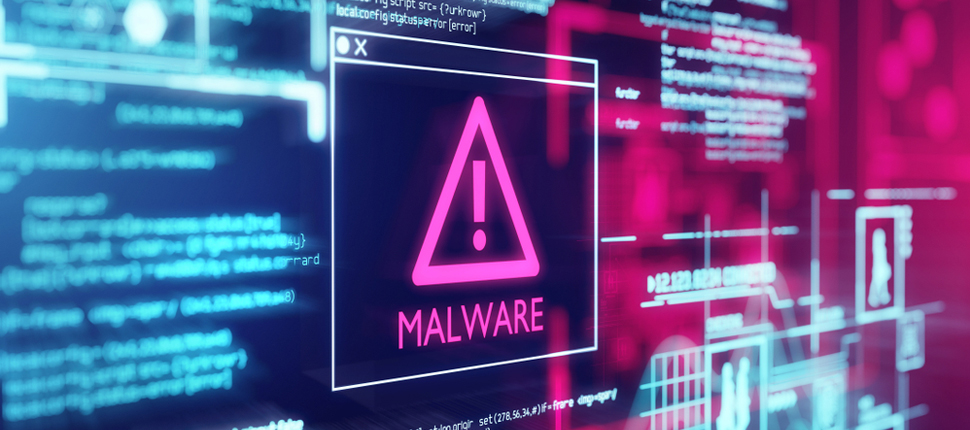

### About the project
Given a dataset of Evasive PDF samples with 21 features containing 500,000 generated evasive samples, 450,000 are malicious and 50,000 are benign PDFs.

The **goal** is to predict which of them are malicious, which are labeled as (1) through the feature named 'class'.

**How will we achieve our goal?**
Through supervised learning model, which we will be trained by training sets and then we will evaluate it using a test set.

### Importing Libraries
First we installed the libraries (pandas,matplotlib,sklearn etc) and then we imported them.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns

### Importing the Dataset from the csv file
 This dataset contains 500,000 generated evasive samples, including 450,000 malicious and 50,000 benign PDFs.

In [9]:
df = pd.read_csv('Evasive-PDF-Samples.csv')
df.head()

#Initialization of the features
features = ['pdfsize', 'pages', 'title characters', 'images', 'obj', 'endobj','stream', 'endstream', 'xref', 
            'trailer', 'startxref', 'ObjStm', 'JS', 'OBS_JS', 'Javascript', 'OBS_Javascript', 'OpenAction', 'OBS_OpenAction',
            'Acroform', 'OBS_Acroform', 'class']

### Data Cleaning
Through data cleaning we detect and correct errors, inconsistencies, and inaccuracies in a dataset to improve its quality and reliability.
1. Handle Missing Values: it seems that in the dataset that was given there are not any missing values so this step can be skipped

In [10]:
print(df.isnull().sum())

pdfsize             0
pages               0
title characters    0
images              0
obj                 0
endobj              0
stream              0
endstream           0
xref                0
trailer             0
startxref           0
ObjStm              0
JS                  0
OBS_JS              0
Javascript          0
OBS_Javascript      0
OpenAction          0
OBS_OpenAction      0
Acroform            0
OBS_Acroform        0
class               0
dtype: int64


2. Remove Duplicates: It seems that the dataset has some dublicates so they are going to be droped.

In [11]:
print(len(df))
df=df.drop_duplicates()
print(len(df))

500000
498318


### Exploratory Data Analysis (EDA)
We are going to visualize our data through two different plot methods in order to understand the distribution and relationships between variables.
1. Histograms

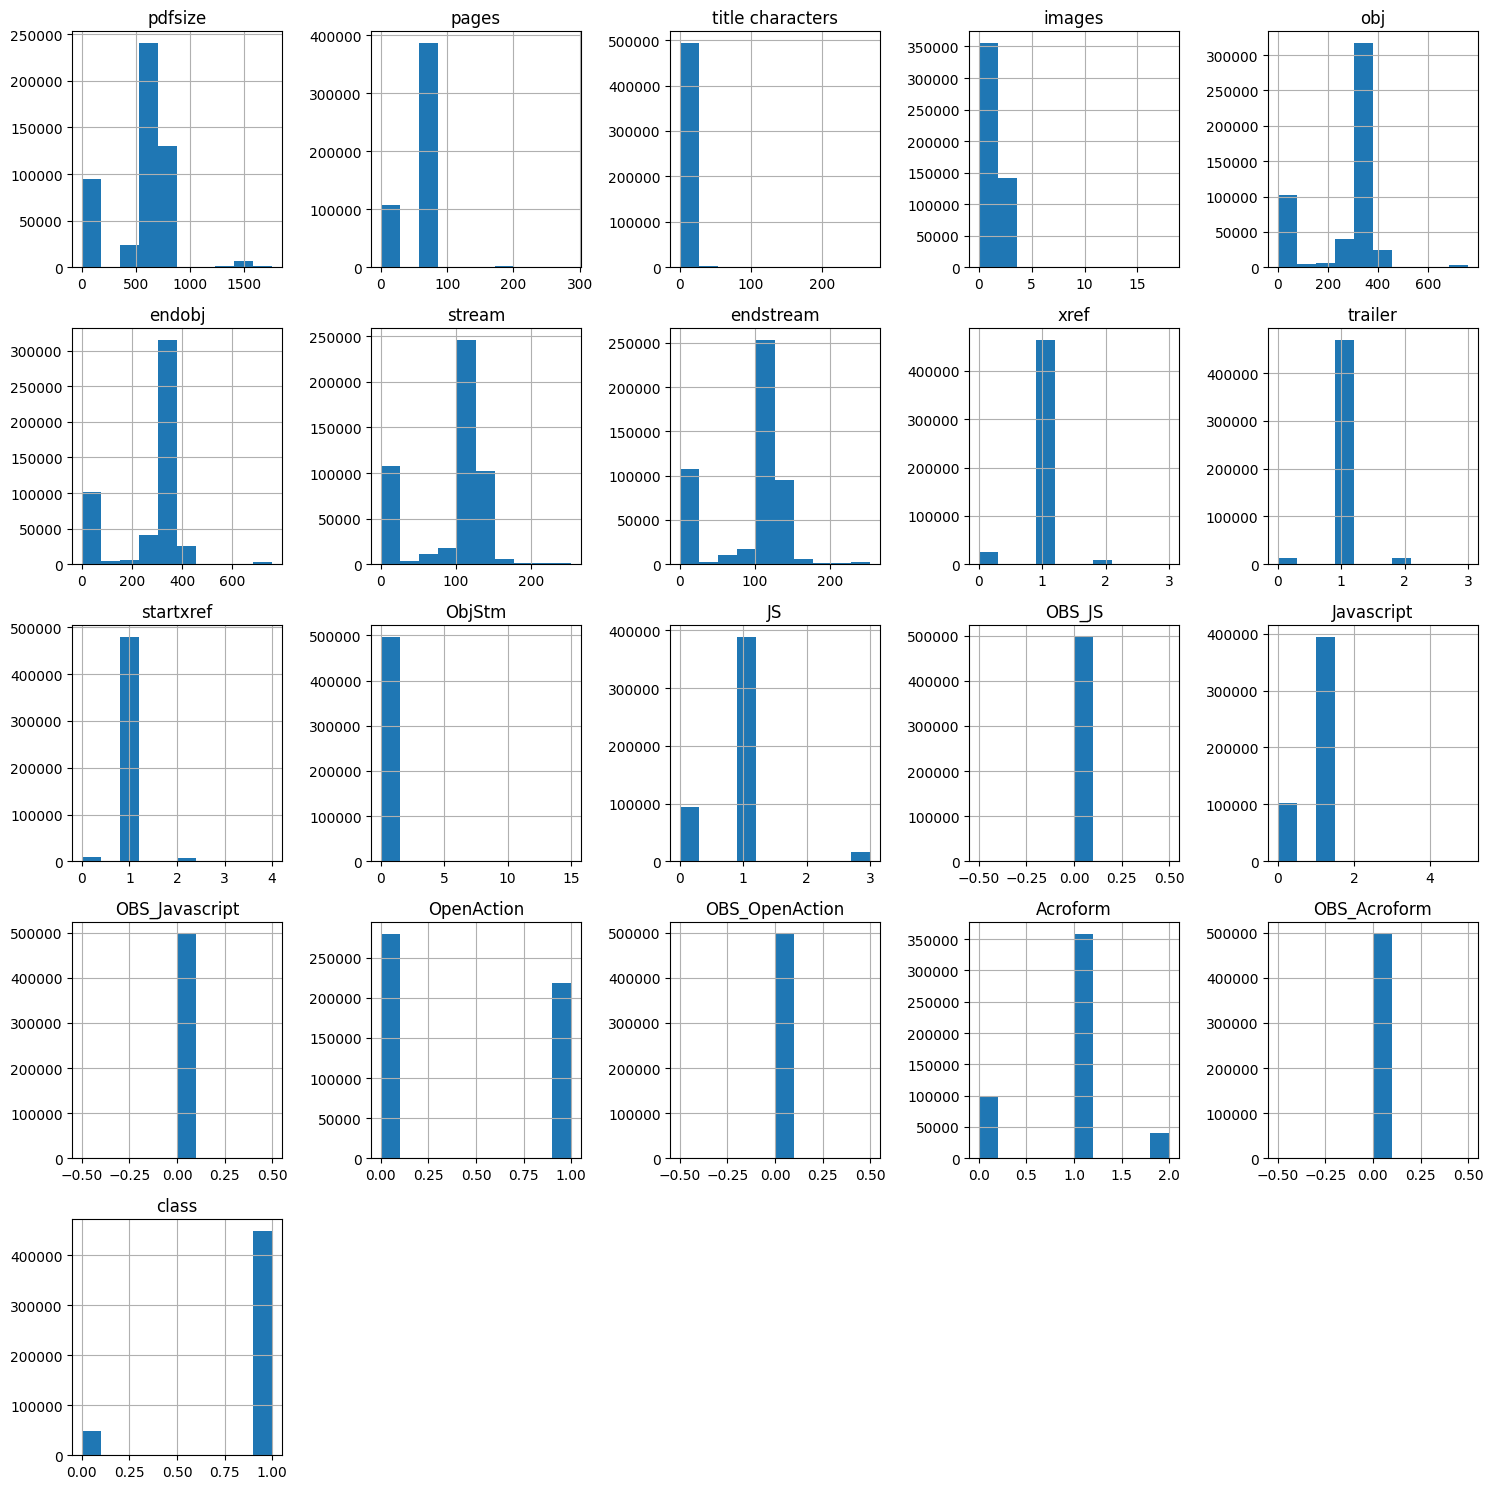

In [12]:
df.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()

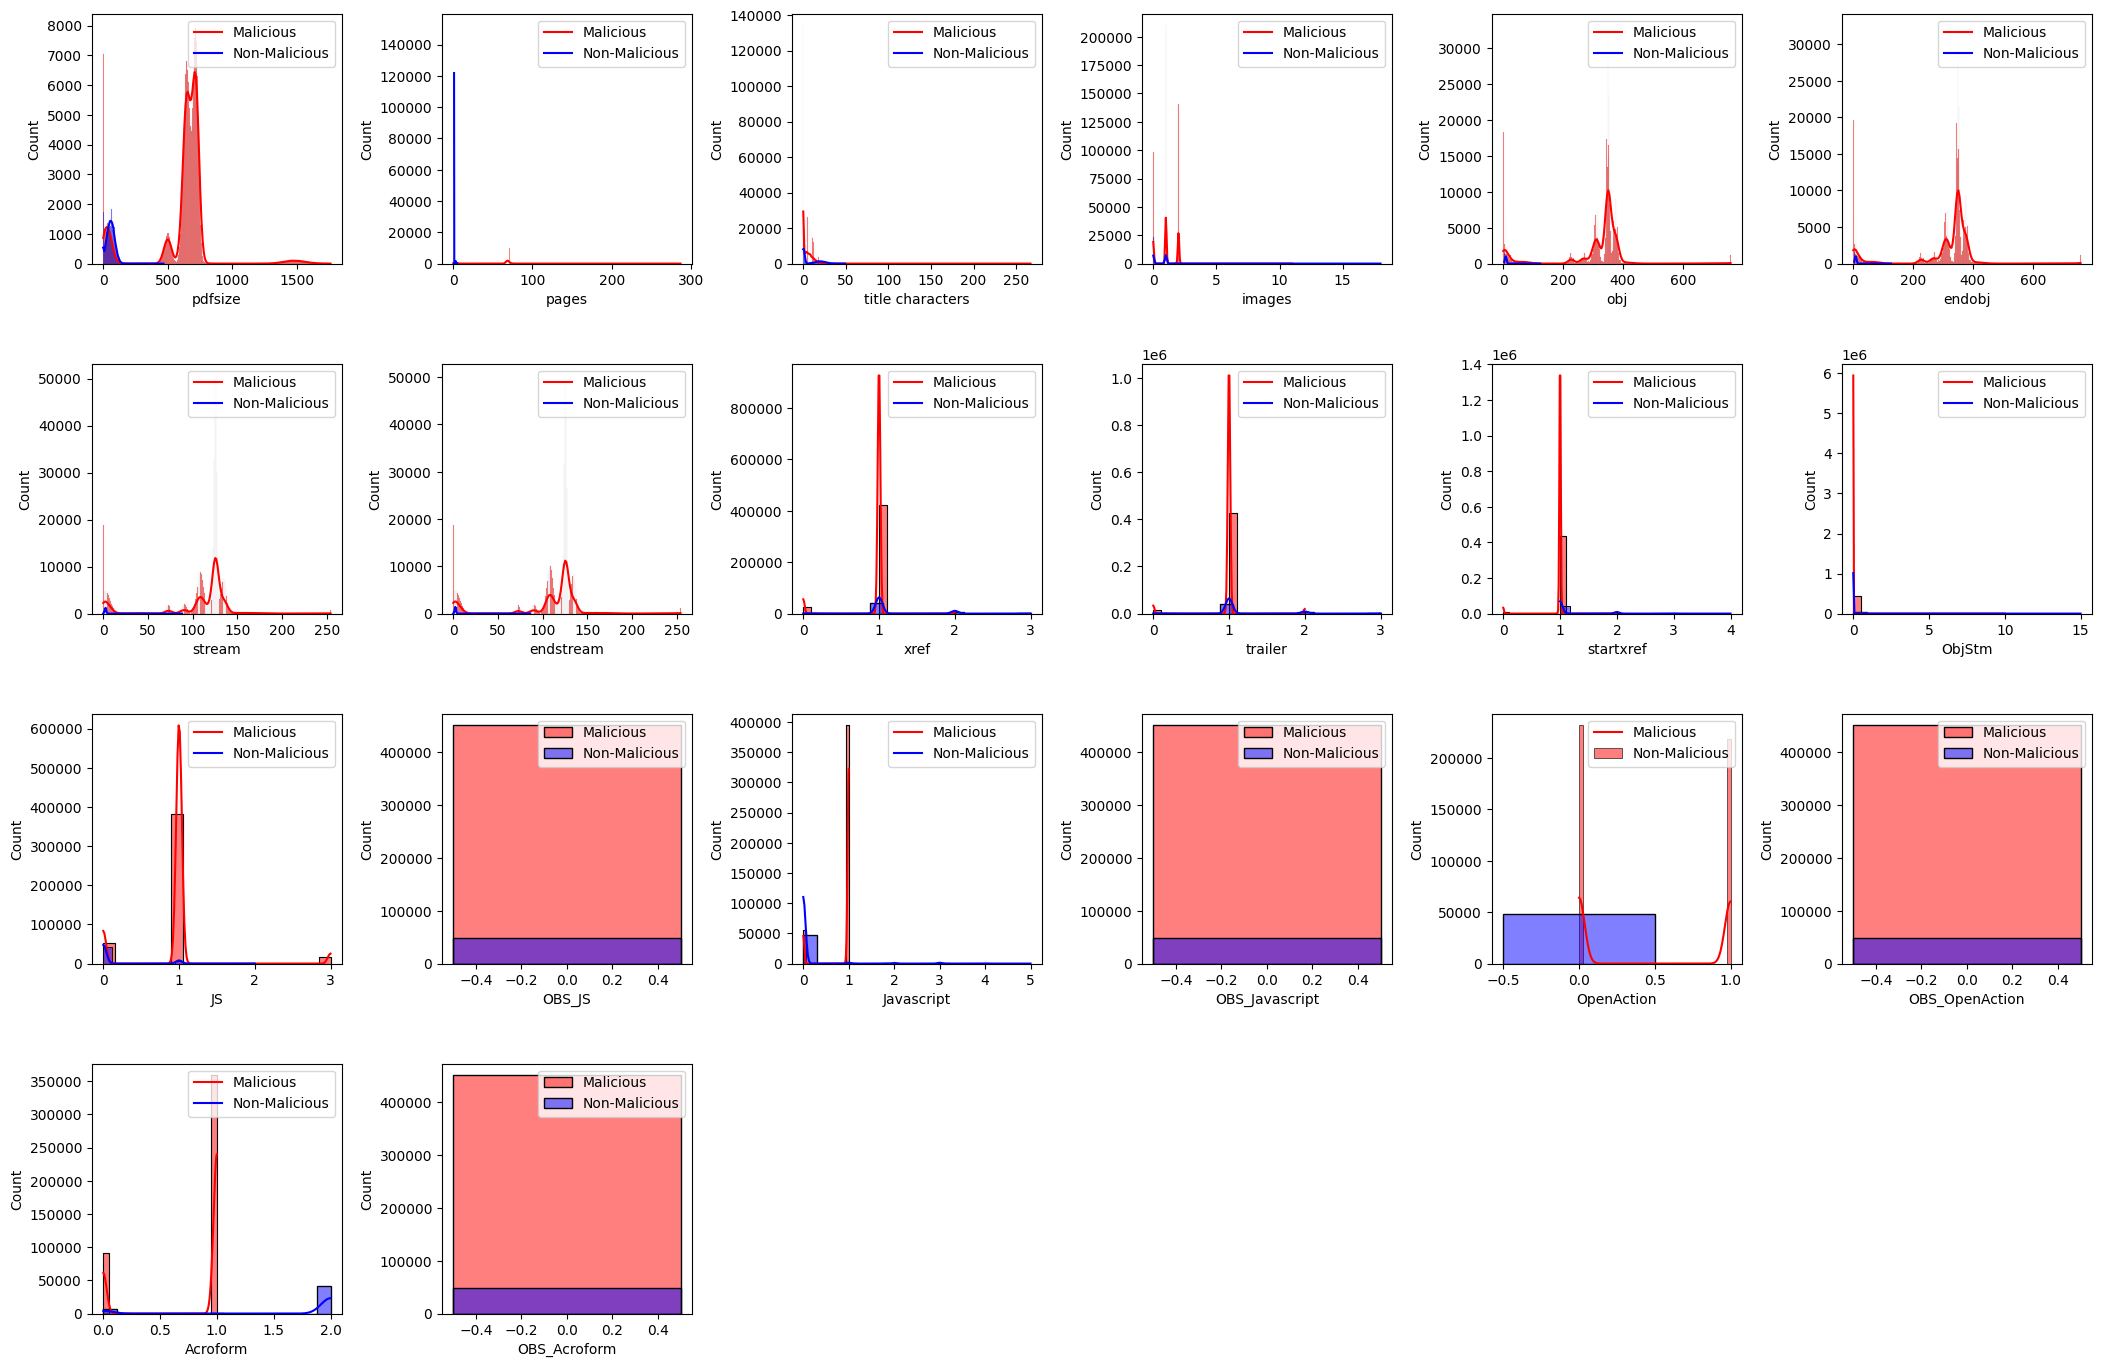

In [15]:
df_malicious = df[df['class'] == 1].drop(['class'], axis=1)
df_non_malicious = df[df['class'] == 0].drop(['class'], axis=1)

# Get the list of column names
cols = list(df_malicious.columns)

# Set up the plot
plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Plot histograms for each feature
for i, col in enumerate(cols):
    plt.subplot(6, 6, i+1)
    sns.histplot(data=df_malicious[col], color='red', label='Malicious', kde=True)
    sns.histplot(data=df_non_malicious[col], color='blue', label='Non-Malicious', kde=True)
    _, axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes, prop={'size': 10})

plt.show()

3. Correlation Matrix: 
Used to understand the relationships between the variables of the dataset see how features are correlated. Will be useful for model training later.


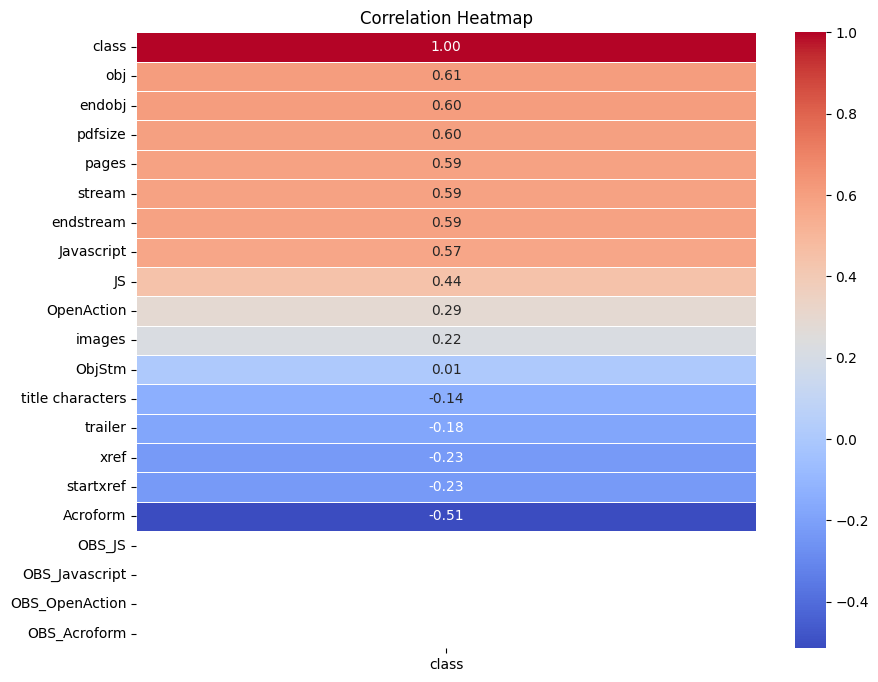

In [14]:

corr = df.corr()[['class']].sort_values(by='class', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)

plt.title('Correlation Heatmap')
plt.show()

### Feature Engineering

1. Data encoding: data needs to be converted into numerical representations since the algorithm input can only be numerical data.
Since there are no categorical variables, there is no need for encoding. Which can be ensured from label encoding since our dataset doesn't change after it:

In [ ]:
#Label Encoding
label_encoder = LabelEncoder()
for feature in features:
    df[feature] = label_encoder.fit_transform(df[feature])
df.head()

,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
0,95323,15,0,1,284,294,128,128,1,1,...,0,1,0,1,0,1,0,1,0,1
1,98851,13,0,1,284,288,124,124,1,1,...,0,1,0,1,0,0,0,1,0,1
2,142668,13,0,1,289,296,128,125,1,1,...,0,1,0,1,0,0,0,1,0,1
3,161276,13,0,0,641,579,250,192,1,1,...,0,1,0,1,0,1,0,1,0,1
4,152714,15,10,2,324,316,141,138,1,1,...,0,1,0,1,0,1,0,1,0,1


3. Scale numerical features: we scale the features to have similar ranges for better algorithm preformance.

In [ ]:
#Standardization
scaler_standardization = StandardScaler()
df[features] = scaler_standardization.fit_transform(df[features])

#Normalization
scaler_normalization = MinMaxScaler()
df[features] = scaler_normalization.fit_transform(df[features])

#Display
df.head()

,pdfsize,pages,title characters,images,obj,endobj,stream,endstream,xref,trailer,...,ObjStm,JS,OBS_JS,Javascript,OBS_Javascript,OpenAction,OBS_OpenAction,Acroform,OBS_Acroform,class
0,0.365878,0.243902,0.000000,0.055556,0.457895,0.461842,0.503937,0.503937,0.333333,0.333333,...,0.0,0.333333,0.0,0.2,0.0,1.0,0.0,0.5,0.0,1.0
1,0.367992,0.236934,0.000000,0.055556,0.457895,0.453947,0.488189,0.488189,0.333333,0.333333,...,0.0,0.333333,0.0,0.2,0.0,0.0,0.0,0.5,0.0,1.0
2,0.395508,0.236934,0.000000,0.055556,0.464474,0.464474,0.503937,0.492126,0.333333,0.333333,...,0.0,0.333333,0.0,0.2,0.0,0.0,0.0,0.5,0.0,1.0
3,0.406535,0.236934,0.000000,0.000000,0.998684,0.877632,0.984252,0.755906,0.333333,0.333333,...,0.0,0.333333,0.0,0.2,0.0,1.0,0.0,0.5,0.0,1.0
4,0.401525,0.243902,0.037453,0.111111,0.510526,0.490789,0.555118,0.543307,0.333333,0.333333,...,0.0,0.333333,0.0,0.2,0.0,1.0,0.0,0.5,0.0,1.0


### Splitting the Dataset
We split the into training, validation, and test sets to evaluate the machine learning model. The training set is used to train the model, while the validation set helps in tuning model parameters and selecting the best configuration, the test set provides an evaluation of the model's performance on unseen data.

In [ ]:

X = df.drop(columns=['class'])  # Features
y = df['class']  # Target variable

# Split the dataset into training and temporary set (80% training and 20% temporary set)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50% validation and 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (398654, 20)
Validation set shape: (49832, 20)
Test set shape: (49832, 20)


### Feature Selection: 
We are going to select the most relevant features that contribute the most predicting the target variable (class) using the correlation matrix method.

### Model Training


Text(0, 0.5, 'pages')

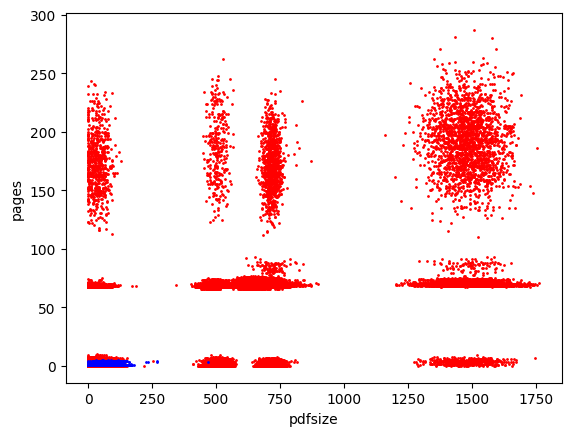

In [ ]:
_df = df[df['class'] == 1]
plt.scatter(_df['pdfsize'], _df['pages'], c='red')
_df = df[df['class'] == 0]
plt.scatter(_df['pdfsize'], _df['pages'], c='blue')
plt.xlabel('pdfsize')
plt.ylabel('pages')

In [ ]:
df['class']

0         1
1         1
2         1
3         1
4         1
         ..
499994    0
499995    0
499996    0
499998    0
499999    0
Name: class, Length: 498318, dtype: int64

In [ ]:
model = LinearRegression()
model.fit(df.drop('class', axis=1), df['class'])
model.coef_

array([ 2.15637613e-04,  9.93021094e-04, -6.09778547e-03, -8.76343204e-03,
        2.20094088e-04,  4.64165072e-05,  7.00946174e-04,  2.10009778e-04,
       -2.05255073e-01, -5.51941628e-03, -5.08339658e-02,  4.38736352e-02,
        2.25702204e-02,  2.08166817e-17,  4.41157921e-02,  0.00000000e+00,
        5.35283219e-02,  0.00000000e+00, -2.62443095e-01,  0.00000000e+00])

In [ ]:
df['pred'] = model.predict(df.drop('class', axis=1)) > 0.5
df['pred']

0          True
1          True
2          True
3          True
4          True
          ...  
499994    False
499995    False
499996    False
499998    False
499999    False
Name: pred, Length: 498318, dtype: bool

In [ ]:
accuracy_score(df['class'], df['pred']), f1_score(df['class'], df['pred'])

(0.9826596671201924, 0.9904357749169591)

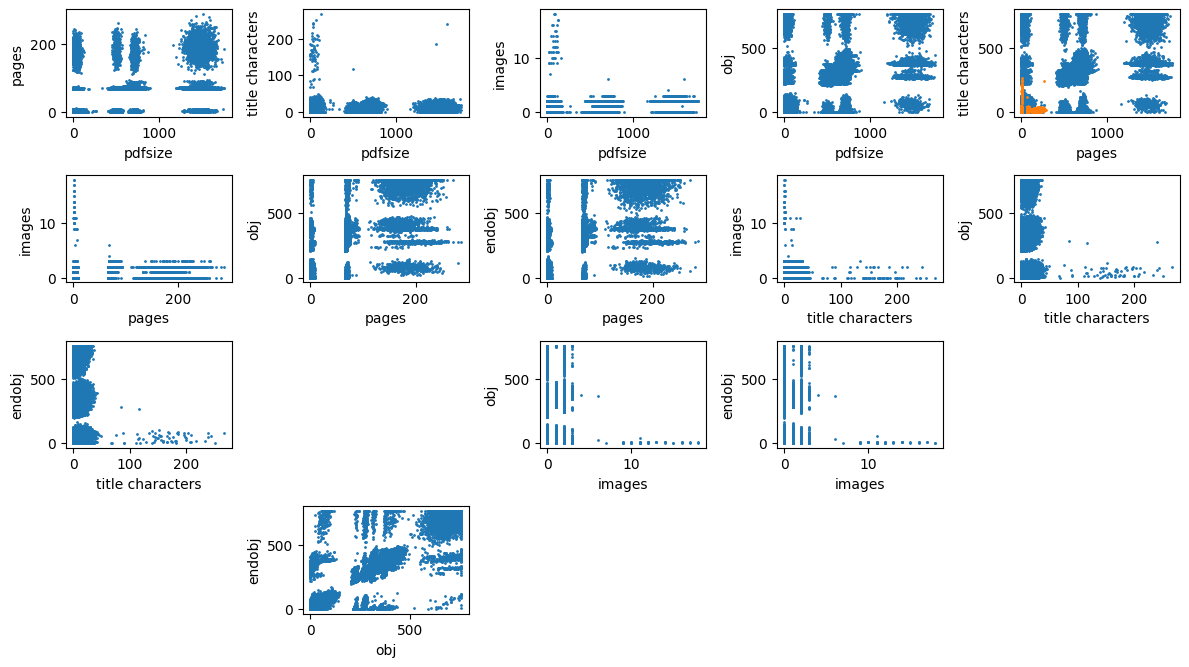

In [ ]:
features = ['pdfsize', 'pages', 'title characters', 'images', 'obj', 'endobj']

# Creating scatter plots
plt.figure(figsize=(12, 8))
for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i < j:
            plt.subplot(5, 5, i * 3 + j)
            plt.scatter(df[feature1], df[feature2], s= 1)
            plt.xlabel(feature1)
            plt.ylabel(feature2)

plt.tight_layout()
plt.show()